In [124]:
from google.colab import files
files.upload()
import os, shutil
os.makedirs('/root/.kaggle', exist_ok=True)
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 600)

!pip install -q kaggle


!kaggle datasets download -d mlg-ulb/creditcardfraud


!unzip -q creditcardfraud.zip


import pandas as pd
df = pd.read_csv('creditcard.csv')

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [125]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# required libraries imported
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [126]:
df.isnull().sum()
df.columns
df['Class'].value_counts()
 # no missing values and highly skewed distribution. No outliers, no categorical columns

,count
Class,
0,284315
1,492


[]

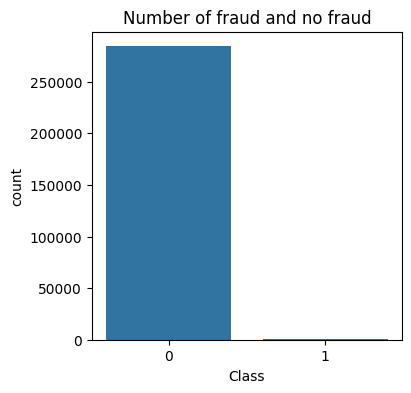

In [127]:
plt.figure(figsize = (4,4))
sns.countplot(x = 'Class',data= df)
plt.title("Number of fraud and no fraud")
plt.plot()



<Axes: xlabel='Amount', ylabel='Density'>

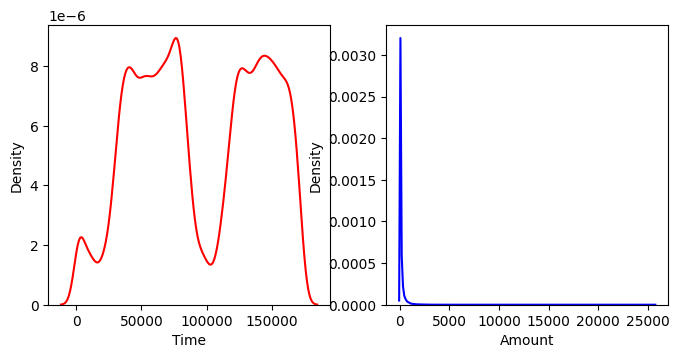

In [128]:
#Now plot the time and amount
plt.figure(figsize = (8,8))
plt.subplot(2,2,1)
sns.kdeplot(df['Time'],color = 'red')
plt.subplot(2,2,2)
sns.kdeplot(df['Amount'],color = 'blue')
#amount skewed

In [129]:
# Except for time and Amount all other values have been scaled.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df['Amount_scaled'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['Time_scaled'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))


In [130]:
# Next the imbalanced dataset is handed through upsampling
from sklearn.utils import resample
major = df[df['Class'] == 1]
minor = df[df['Class'] == 0]
y_upsampled = resample(minor,replace = True,n_samples = int(len(major)*0.80),random_state = 42)
df_upsampled = pd.concat([major,y_upsampled])
df_upsampled = df_upsampled.sample(frac = 1,random_state = 42)
df_upsampled['Class'].value_counts()






,count
Class,
1,492
0,393


<Axes: >

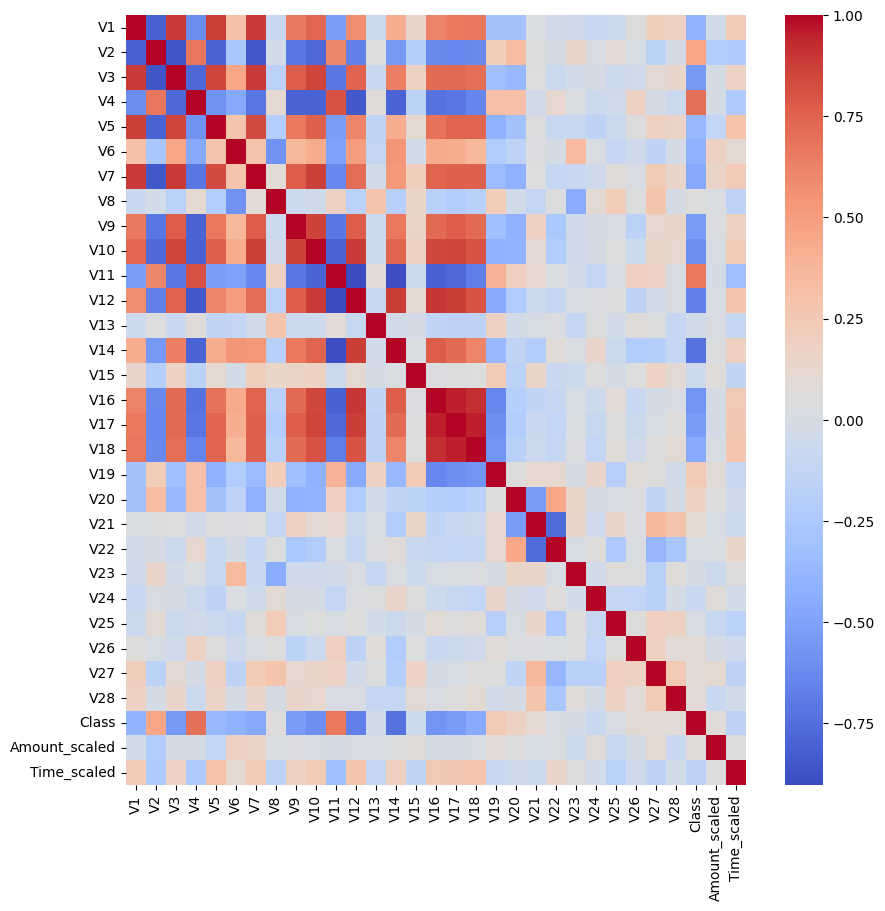

In [114]:
# Now, we check for outliers mainly extreme ones and correlation between data
corr = df_upsampled.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr,cmap = "coolwarm")

<Axes: xlabel='Class', ylabel='V10'>

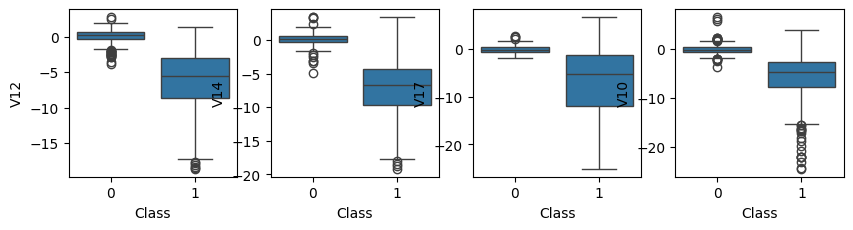

In [66]:
plt.figure(figsize = (10,10))
plt.subplot(4,4,1)
sns.boxplot(x = 'Class', y = 'V12',data = df_upsampled)
plt.subplot(4,4,2)
sns.boxplot(x = 'Class', y = 'V14',data = df_upsampled)
plt.subplot(4,4,3)
sns.boxplot(x = 'Class', y = 'V17',data = df_upsampled)
plt.subplot(4,4,4)
sns.boxplot(x = 'Class', y = 'V10',data = df_upsampled)
## we need to remove extreme outliers by setting thresholds


In [78]:
v14 = df_upsampled['V14'].loc[df_upsampled['Class'] == 1].values
q25,q75 = np.percentile(v14,[25,75])
iqr = q75 - q25
v14_lower, v14_upper = q25 - iqr*1.5, q75 + iqr*1.5
outliers = [x for x in v14 if x<q25 - 1.5*iqr or x>q75 + 1.5*iqr]
print(outliers)


df_upsampled = df_upsampled.drop(df_upsampled[(df_upsampled['V14']< v14_lower) | (df_upsampled['V14']> v14_upper)].index)
v10 = df_upsampled['V10'].loc[df_upsampled['Class']==1].values
q25,q75 = np.percentile(v10,[25,75])
iqr = q75-q25
v10_lower,v10_upper = q25 - iqr*1.5,q75 + iqr*1.5
outliers = [x for x in v10 if x<v10_lower or x>v10_upper]
print(outliers)
df_upsampled = df_upsampled.drop(df_upsampled[(df_upsampled['V10']<v10_lower)|(df_upsampled['V10']>v10_upper)].index)


[np.float64(-18.4937733551053), np.float64(-19.2143254902614), np.float64(-18.8220867423816), np.float64(-18.0499976898594)]


In [84]:
#Seperate the data into input and output variables
x = df_upsampled.drop('Class',axis = 1)
y = df_upsampled['Class']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.4,random_state = 42)
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
penalty = ['l1','l2','elasticnet']
c_values = [1,0.1,10]
solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
params = {'penalty':penalty,'C':c_values,'solver': solver}
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits = 5)
grid=GridSearchCV(estimator = logistic,param_grid = params,cv = 5,n_jobs= -1)
grid.fit(X_train,y_train)

best_score = grid.best_params_
best_score



/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
150 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solv

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

In [131]:
# Train the data with se;ected parameters and determine accuracy of prediction
x = df_upsampled.drop('Class',axis = 1)
y = df_upsampled['Class']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.4,random_state = 42)
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(C= 0.1, penalty ='l1', solver = 'liblinear')
logistic.fit(X_train,y_train)
y_pred = logistic.predict(X_test)
from sklearn.metrics import accuracy_score,confusion_matrix
print("Accuracy is:",round(accuracy_score(y_test,y_pred),5)*100,"%")
print("Confusion matrix:",confusion_matrix(y_test,y_pred),sep = '\n')




Accuracy is: 94.35 %
Confusion matrix:
[[154   2]
 [ 18 180]]


0.9783411033411034


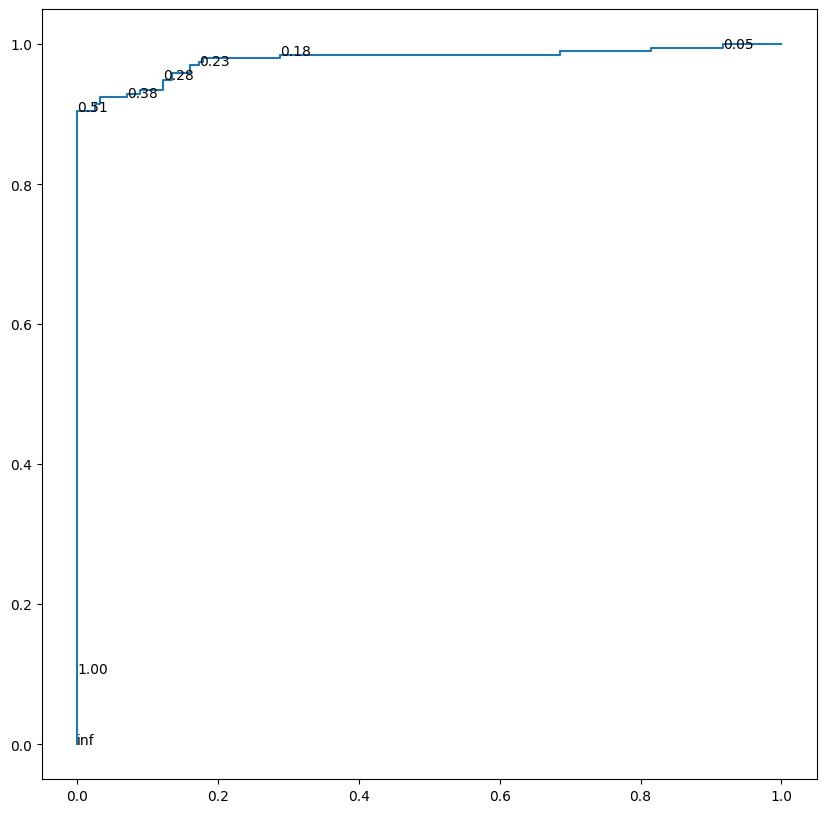

In [115]:
#Plot the roc auc curve
from sklearn.metrics import roc_auc_score, roc_curve
y_pred_prob = logistic.predict_proba(X_test)[:,1]
model_auc = roc_auc_score(y_test,y_pred_prob)
print(model_auc)
model_fpr,model_tpr,thresholds = roc_curve(y_test,y_pred_prob)
plt.figure(figsize = (10,10))
plt.plot(model_fpr,model_tpr,label = 'logistic')
for i, (x,y,z) in enumerate(zip(model_fpr,model_tpr,thresholds)):
  if i%5 == 0:
    plt.annotate(f'{z:.2f}' , (x,y))
plt.show()

In [ ]:
#We finally attain a model with prediction accuracy of 94.633% and roc-auc score of 0.978

In [132]:
import pickle
pickle.dump(logistic,open('Credit_card_fraud_pkl','wb'))